In [10]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt


In [101]:
CHANNEL = "A-3"

In [12]:
class Channel:
    def __init__(self, chan_id):
        self.id = chan_id
        self.train = None
        self.test = None
        self.l_s = 250
        self.n_predictions = 10
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_hat = None

    def shape_data(self, arr, training=True):
        data = []
        for i in range(len(arr) - self.l_s - self.n_predictions):
            data.append(arr[i: i + self.l_s + self.n_predictions])
            
        data = np.array(data)

        if training:
            np.random.shuffle(data)
            self.X_train = data[:, :-self.n_predictions, :]
            self.y_train = data[:, -self.n_predictions:, 0]
        else:
            self.X_test = data[:, :-self.n_predictions, :]
            self.y_test = data[:, -self.n_predictions:, 0]

    def load_data(self):
        try:
            self.train = np.load(os.path.join("data", "train", "{}.npy".format(self.id)))
            self.test = np.load(os.path.join("data", "test", "{}.npy".format(self.id)))
        except FileNotFoundError as e:
            print(e)

        self.shape_data(self.train)
        self.shape_data(self.test, training=False)

In [102]:
new_channel = Channel(CHANNEL)
new_channel.load_data()

In [103]:
new_channel.X_train.shape[2]

25

In [104]:
new_channel.test.shape

(8205, 25)

In [105]:
new_channel.test.shape
new_channel.X_test.shape
new_channel.X_test.shape

(7945, 250, 25)

In [106]:
new_channel.train

array([[0.11308108, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11308108, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3336605 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.76415679, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76415679, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76415679, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [107]:
from keras_core.models import Sequential, load_model
from keras_core.callbacks import History, EarlyStopping
from keras_core.layers import Dense, Activation, Dropout, LSTM

class Model:
    def __init__(self, channel):
        self.chan_id = channel.id
        self.y_hat = np.array([])
        self.model = None
        self.train_new(channel)
        

    def train_new(self, channel):
        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=10,
                                        min_delta=0.0003,
                                        verbose=0)]

        self.model = Sequential()

        self.model.add(LSTM(
            80,
            input_shape=(None, channel.X_train.shape[2]),
            return_sequences=True))
        self.model.add(Dropout(0.3))

        self.model.add(LSTM(
            80,
            return_sequences=False))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(
            channel.n_predictions))
        self.model.add(Activation('linear'))

        self.model.compile(loss='mse',
                           optimizer='adam')

        self.model.fit(channel.X_train,
                       channel.y_train,
                       batch_size=64,
                       epochs=35,
                       validation_split=0.2,
                       callbacks=cbs,
                       verbose=True)
        
    def aggregate_predictions(self, y_hat_batch, method='first'):
        agg_y_hat_batch = np.array([])

        for t in range(len(y_hat_batch)):

            start_idx = t - 10
            start_idx = start_idx if start_idx >= 0 else 0

            # predictions pertaining to a specific timestep lie along diagonal
            y_hat_t = np.flipud(y_hat_batch[start_idx:t+1]).diagonal()

            if method == 'first':
                agg_y_hat_batch = np.append(agg_y_hat_batch, [y_hat_t[0]])
            elif method == 'mean':
                agg_y_hat_batch = np.append(agg_y_hat_batch, np.mean(y_hat_t))

        agg_y_hat_batch = agg_y_hat_batch.reshape(len(agg_y_hat_batch), 1)
        self.y_hat = np.append(self.y_hat, agg_y_hat_batch)
              
    def batch_predict(self, channel):
        num_batches = int((channel.y_test.shape[0] - 250)
                          / 70)

        for i in range(0, num_batches + 1):
            prior_idx = i * 70
            idx = (i + 1) * 70

            if i + 1 == num_batches + 1:
                idx = channel.y_test.shape[0]

            X_test_batch = channel.X_test[prior_idx:idx]
            y_hat_batch = self.model.predict(X_test_batch)
            self.aggregate_predictions(y_hat_batch)

        self.y_hat = np.reshape(self.y_hat, (self.y_hat.size,))

        channel.y_hat = self.y_hat

        return channel


In [108]:
model = Model(new_channel)

Epoch 1/35


/home/stoakman/anaconda3/envs/tf/lib/python3.9/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1671 - val_loss: 0.0318
Epoch 2/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0417 - val_loss: 0.0236
Epoch 3/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0383 - val_loss: 0.0227
Epoch 4/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0333 - val_loss: 0.0221
Epoch 5/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0325 - val_loss: 0.0226
Epoch 6/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0316 - val_loss: 0.0222
Epoch 7/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0292 - val_loss: 0.0215
Epoch 8/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0285 - val_loss: 0.0219
Epoch 9/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0305 - val_loss: 0.0212
Epoch 10/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0275 - val_loss: 0.0209
Epoch 11/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0267 - val_loss: 0.0203
Epoch 12/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0289 - val_l

In [109]:
model.batch_predict(new_channel)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━

In [110]:
new_channel.y_hat.shape

(7945,)

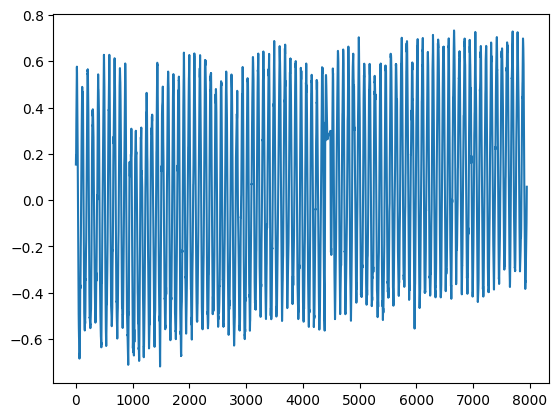

In [111]:
plt.plot(new_channel.y_hat)

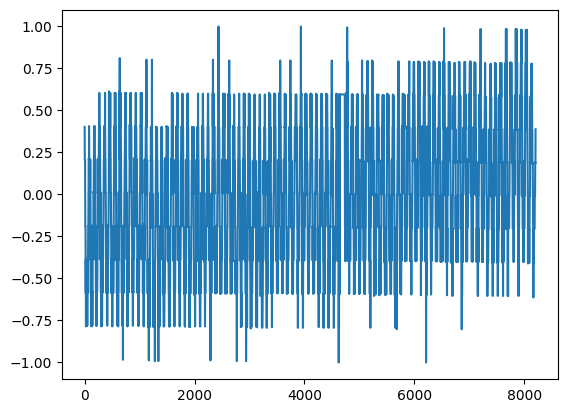

In [112]:
plt.plot(new_channel.test[:, 0])

In [113]:
import pandas as pd
anomalies = pd.read_csv("data/labeled_anomalies.csv")
anomalies = anomalies[anomalies["chan_id"] == "E-10"]
anomalies_plot = anomalies['anomaly_sequences']
anomalies_plot = eval(anomalies_plot.iloc[0])

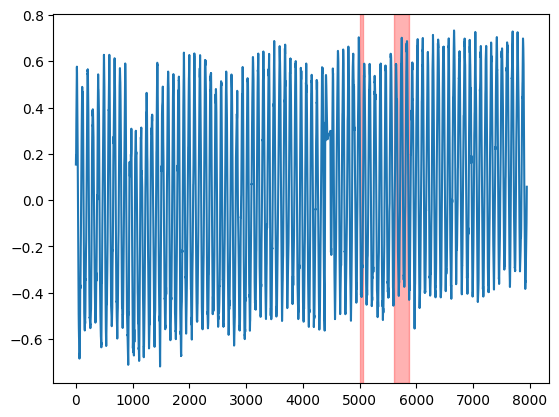

In [114]:
plt.plot(new_channel.y_hat)
for rect in anomalies_plot:
    plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
plt.show()

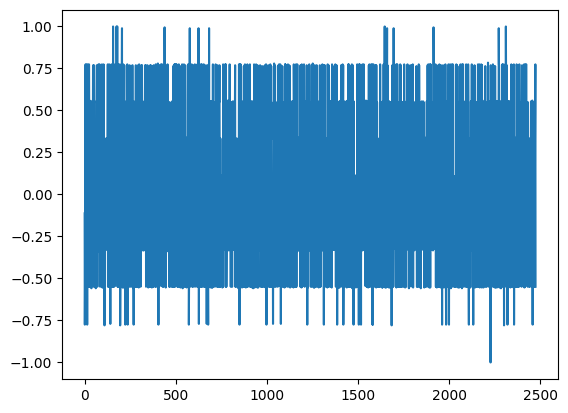

In [25]:
plt.plot(new_channel.X_train[:, -1, 0])

(2476, 10)

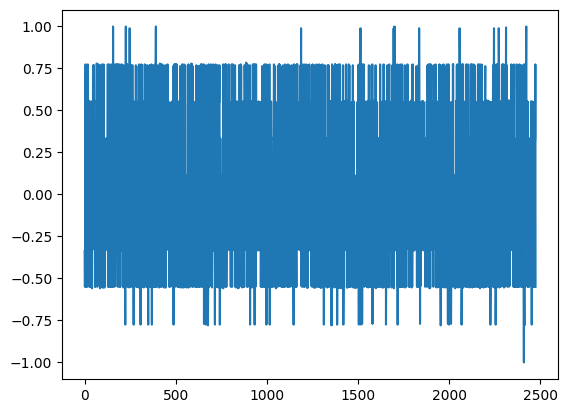

In [26]:
plt.plot(new_channel.y_train[:, 0])
new_channel.y_train.shape